In [1]:
from nerf.model import NeRF
from nerf.dataset import PixelRayDataset

In [2]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import cv2
import os
import io

In [3]:
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.autograd as autograd

In [4]:
tiny_nerf_data = np.load('tiny_nerf_data.npz')
images = tiny_nerf_data['images']
poses = tiny_nerf_data['poses']

H, W = images.shape[1:3]
focal_length = float(tiny_nerf_data['focal'])

In [5]:
test_image = images[-1]
test_pose = poses[-1]

test_image = torch.FloatTensor([test_image]).cuda()
test_pose = torch.FloatTensor([test_pose]).cuda()

images = images[:-1]
poses = poses[:-1]

images = torch.FloatTensor(images).cuda()
poses = torch.FloatTensor(poses).cuda()

/home/btrabucco/anaconda3/envs/nerf/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


In [6]:
dataset = PixelRayDataset(images, poses, focal_length)
data_loader = data.DataLoader(dataset, batch_size=1024, shuffle=True)

/home/btrabucco/anaconda3/envs/nerf/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
nerf = NeRF(normalize_position=6.0).cuda()

In [8]:
nerf_optimizer = optim.Adam(nerf.parameters(), lr=0.0001)

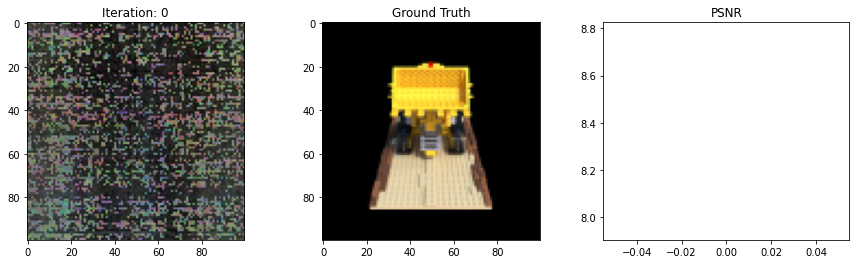

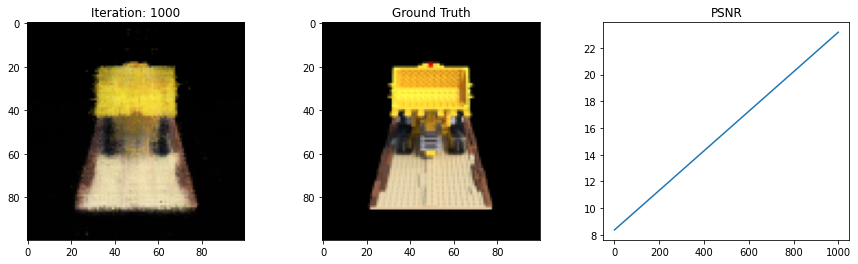

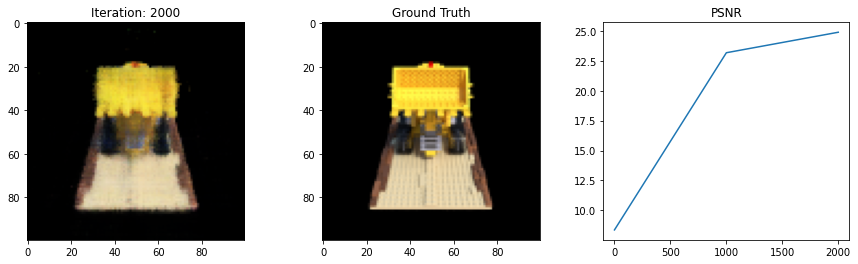

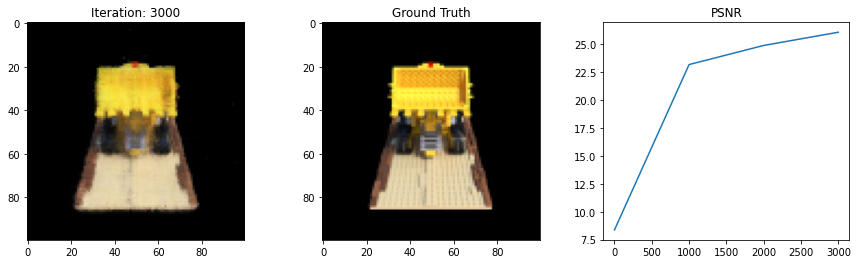

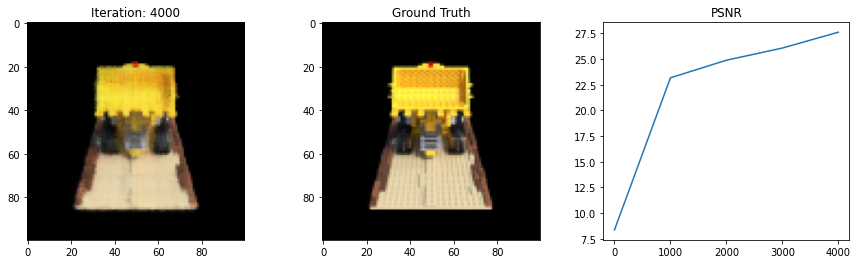

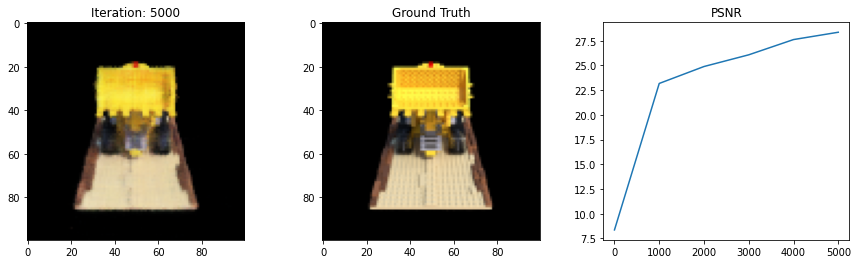

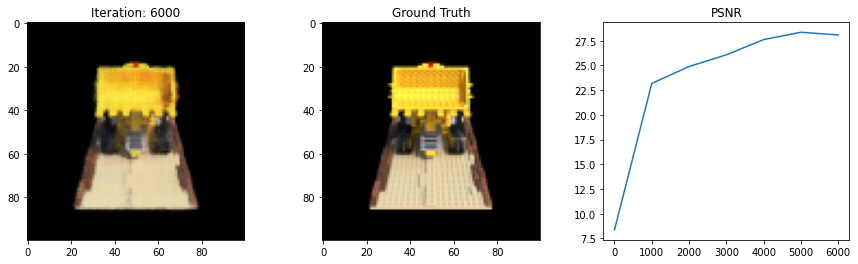

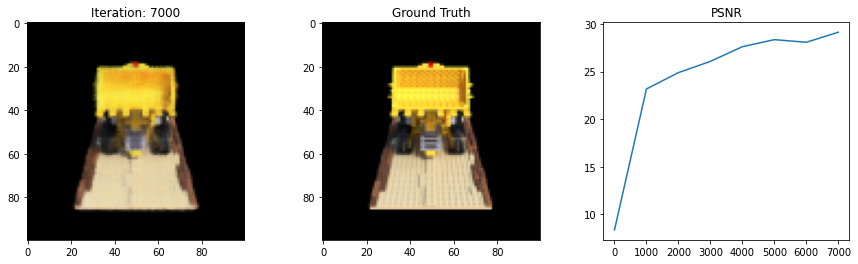

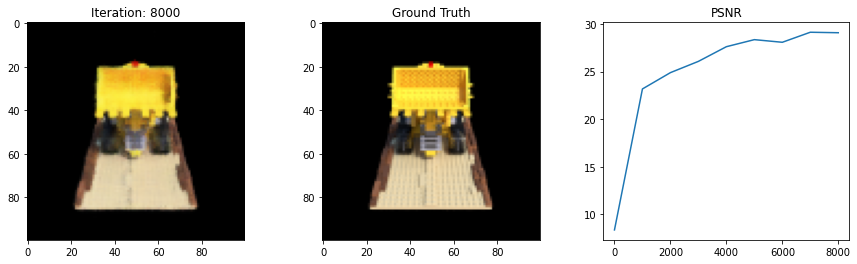

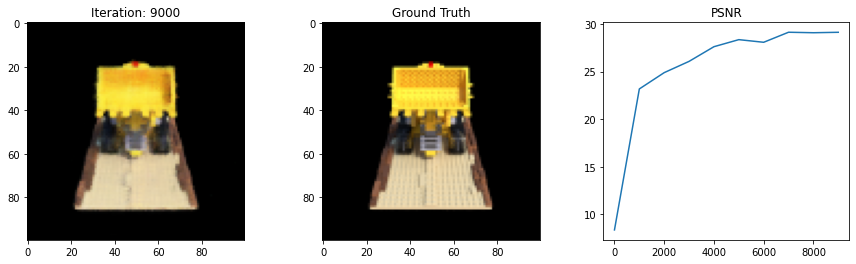

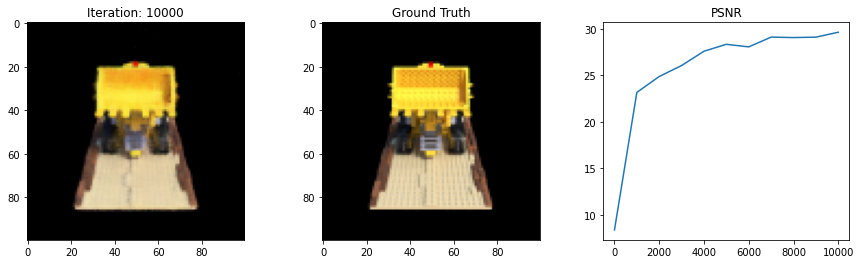

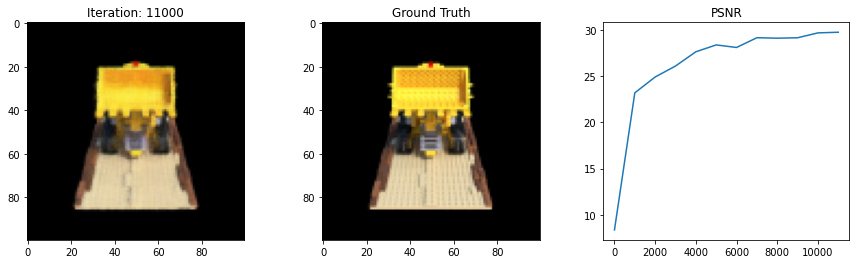

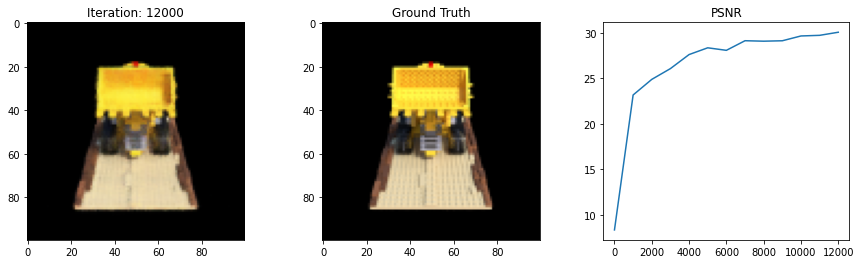

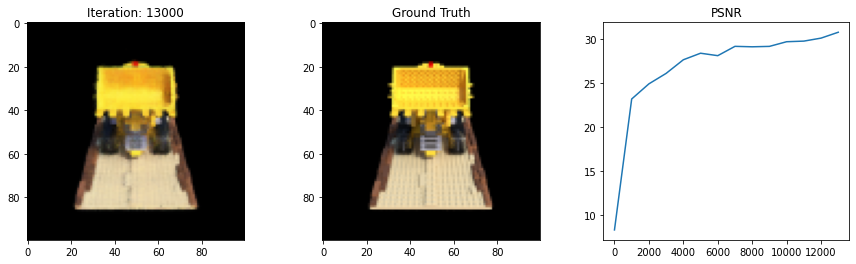

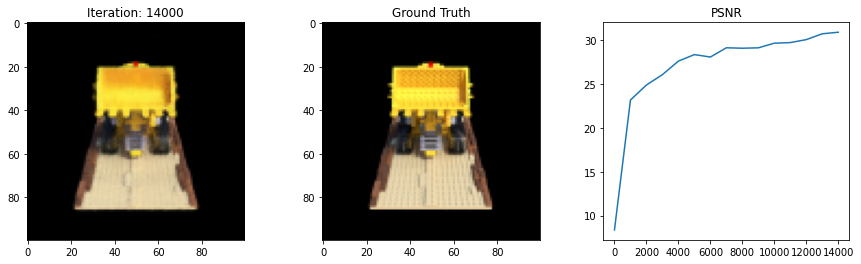

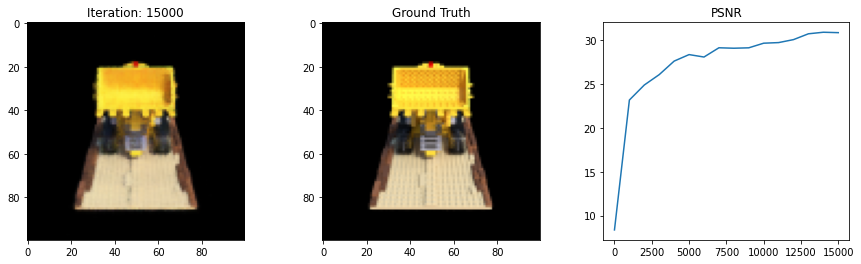

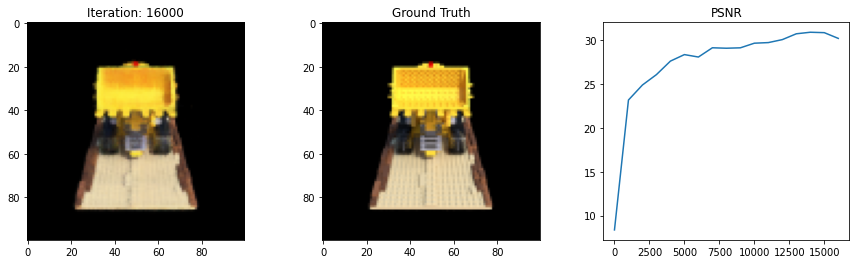

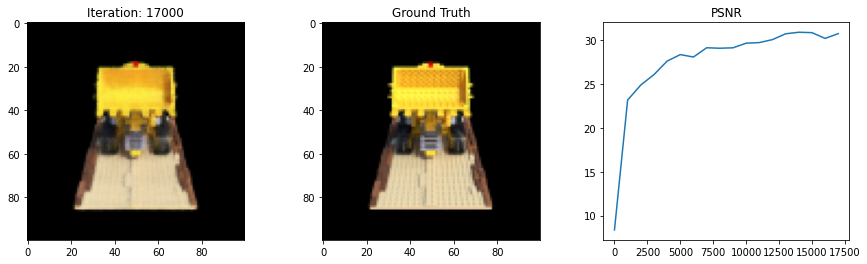

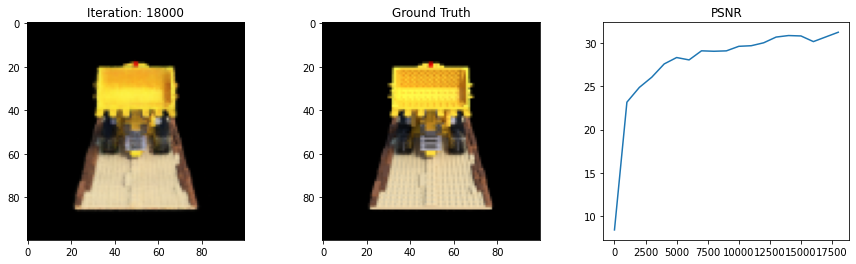

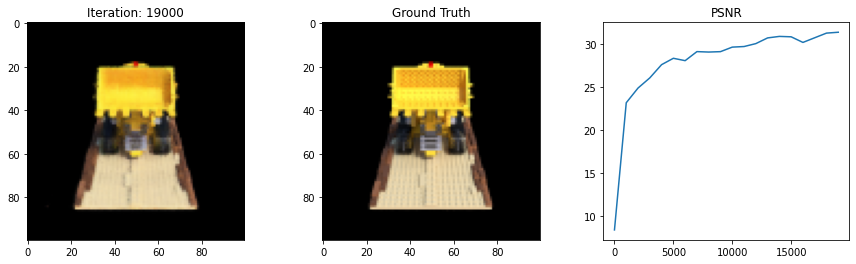

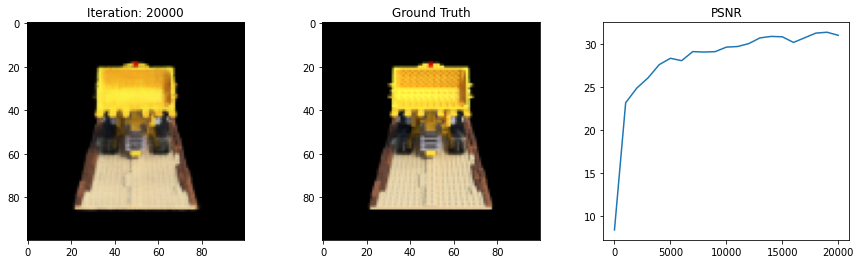

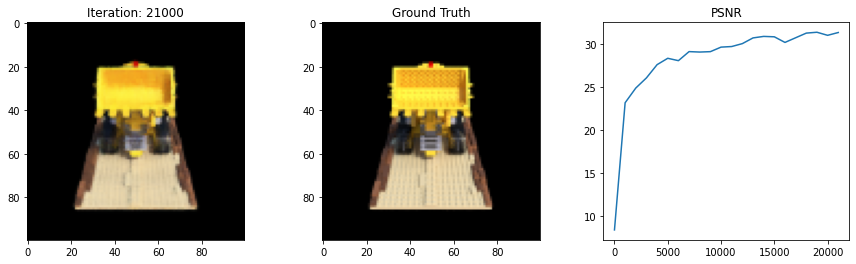

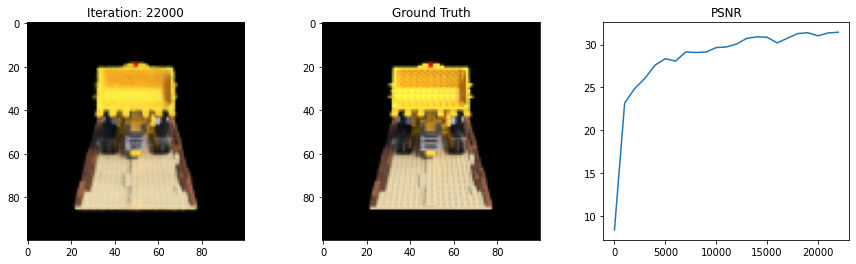

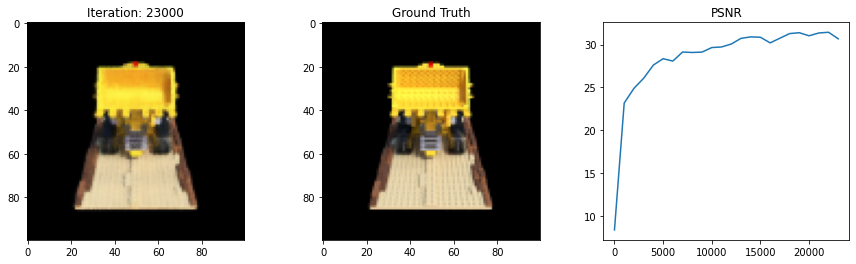

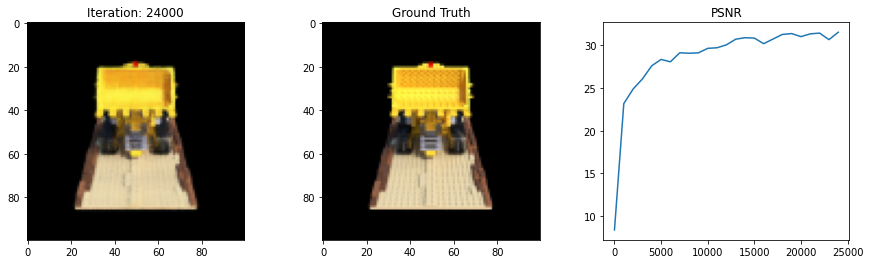

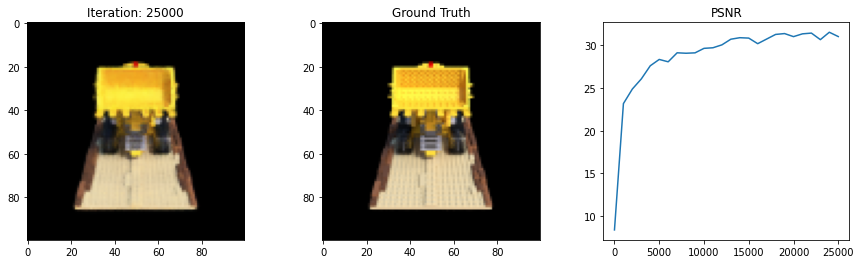

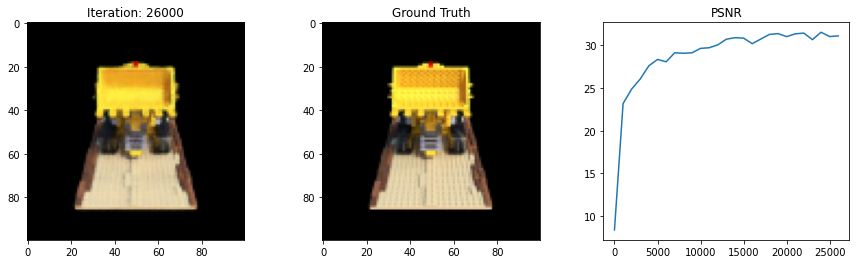

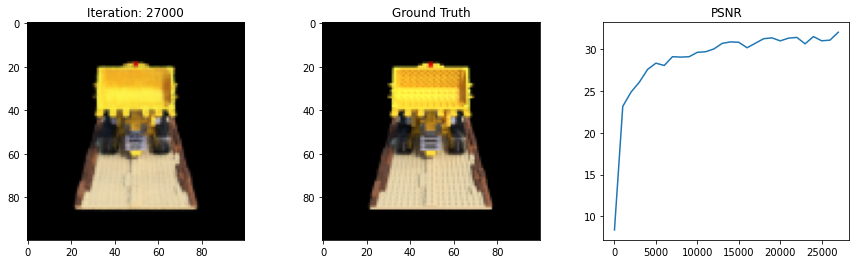

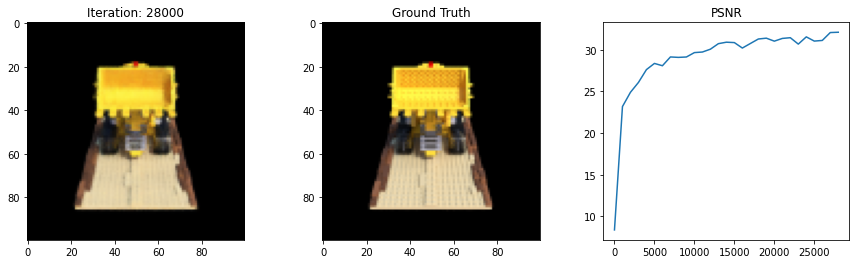

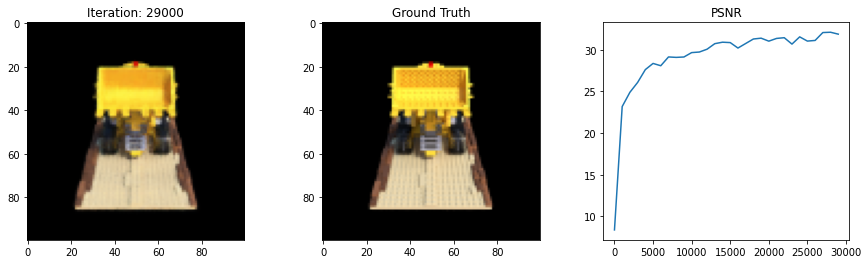

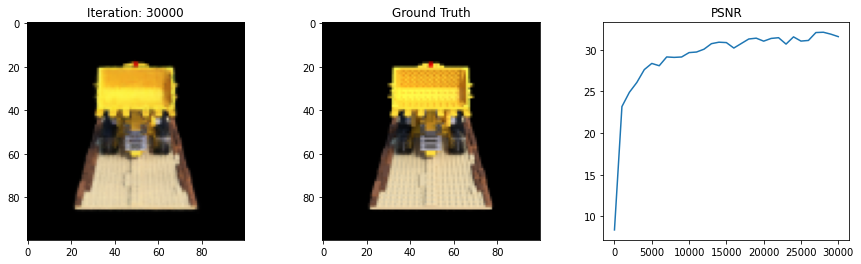

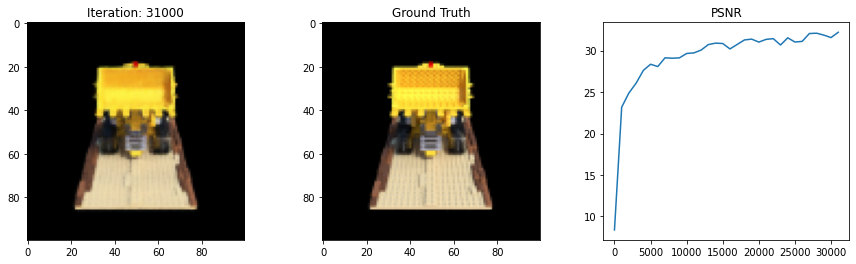

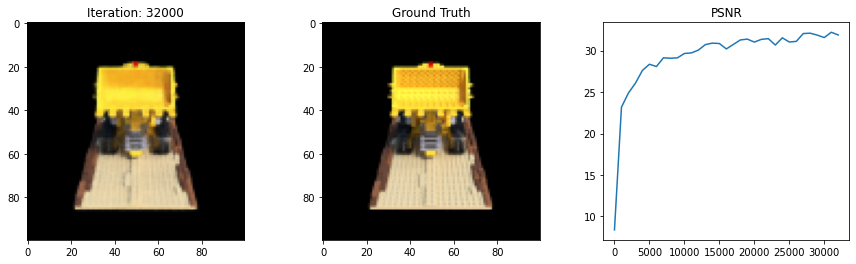

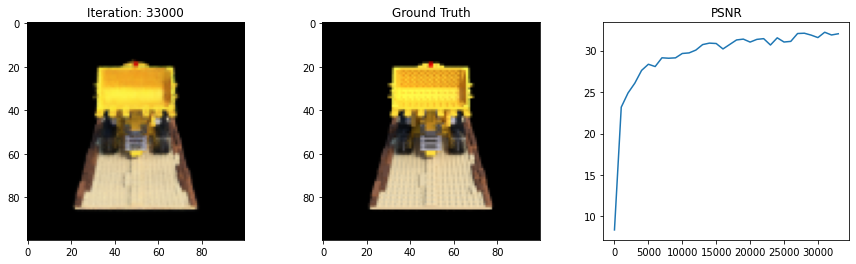

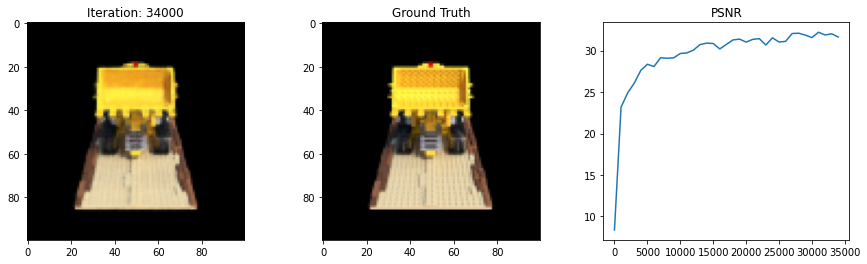

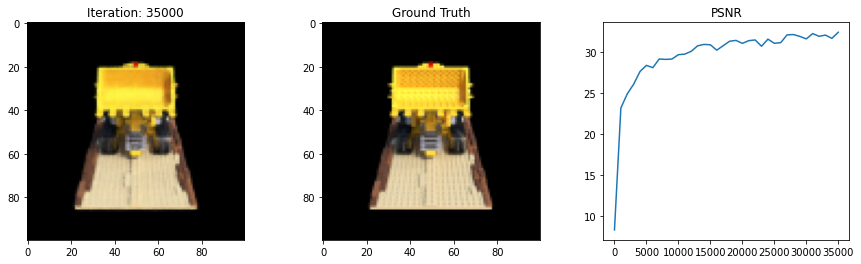

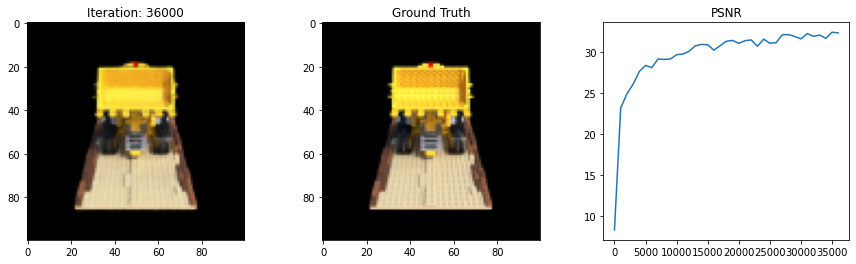

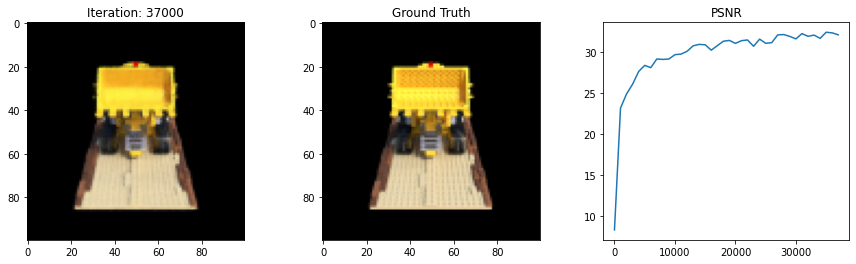

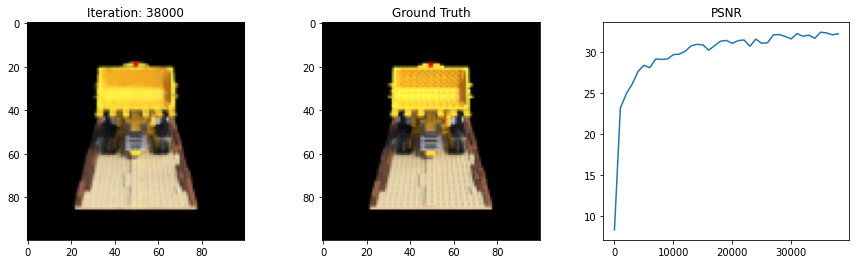

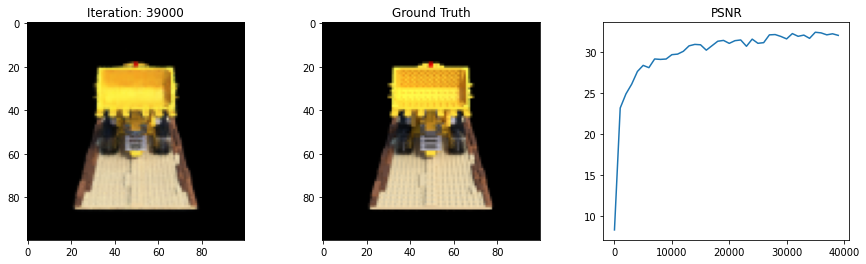

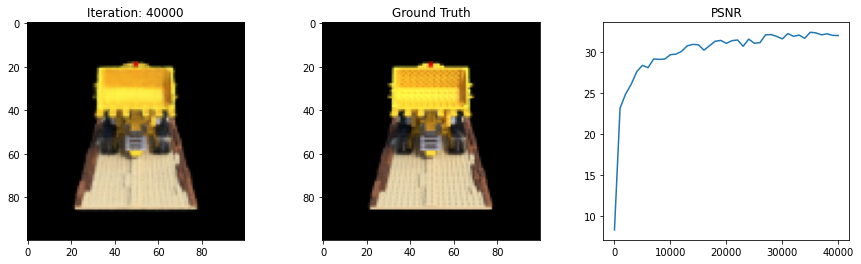

KeyboardInterrupt: 

In [9]:
psnrs = []
iternums = []

iteration = -1
for epoch in range(100):
    for batch in data_loader:
        
        iteration += 1
        
        pixels = nerf.render_rays(
            batch['rays_o'],
            batch['rays_d'],  
            2.0, 
            6.0, 
            64, 
            randomly_sample=True, 
            density_noise_std=1.0)

        nerf_optimizer.zero_grad()

        ((pixels - batch['pixels']) ** 2).mean().backward()

        nerf_optimizer.step()
        
        if iteration % 1000 == 0:
            
            with torch.no_grad():
                
                test_render = nerf.render_image(
                    test_pose[..., :3,  3], 
                    test_pose[..., :3, :3],  
                    H, 
                    W, 
                    focal_length, 
                    2.0, 
                    6.0, 
                    64)
        
                psnr = -10.0 * torch.log(((
                    test_render - 
                    test_image) ** 2).mean()) / 2.30258509299
            
                psnrs.append(psnr.cpu().detach().numpy())
                iternums.append(iteration)
        
            plt.figure(figsize=(15,4))
            
            plt.subplot(131)
            plt.title(f'Iteration: {iteration}')
            plt.imshow(test_render[0].detach().cpu().numpy())
            
            plt.subplot(132)
            plt.title('Ground Truth')
            plt.imshow(test_image[0].detach().cpu().numpy())
            
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            
            plt.show()

In [10]:
torch.save(nerf.state_dict(), "nerf.pth")